## Data Preparation and Analysis

Missing values in General Dataset:
DATE                          0
GENERAL_DAM_OCCUPANCY_RATE    0
GENERAL_DAM_RESERVED_WATER    0
dtype: int64


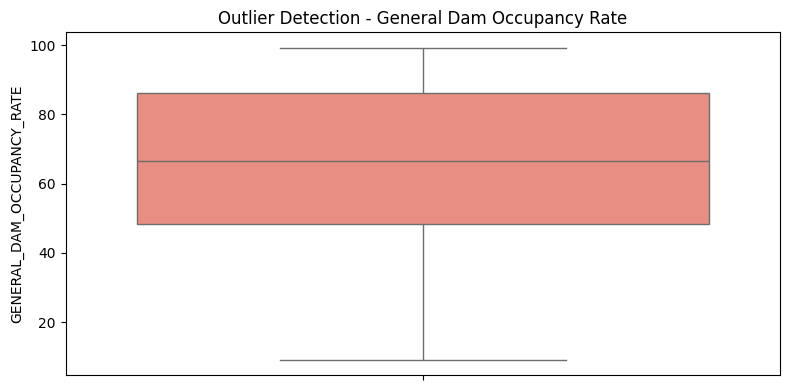

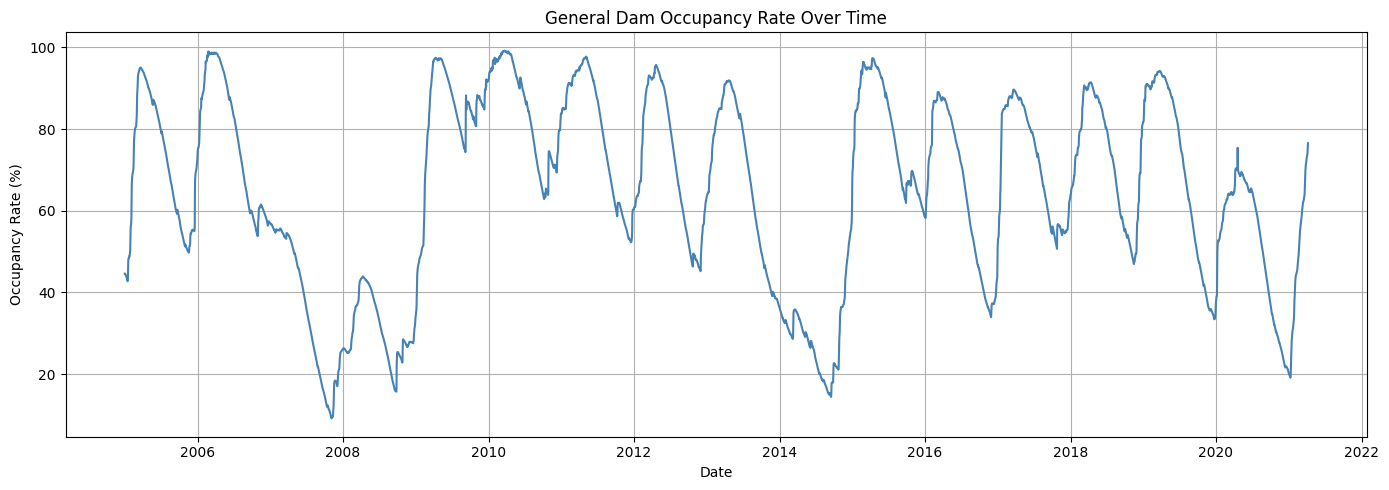


Missing values in Dam-Specific Dataset:
Tarih           0
Omerli          0
Darlik          0
Elmali          0
Terkos          0
Alibey          0
Buyukcekmece    0
Sazlidere       0
Kazandere       0
Pabucdere       0
Istrancalar     0
dtype: int64


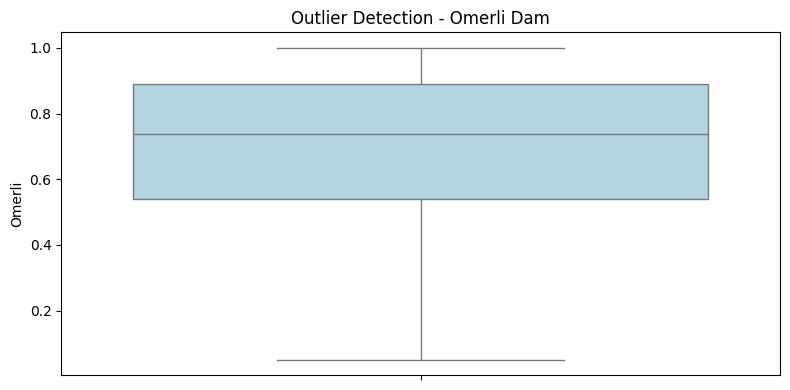

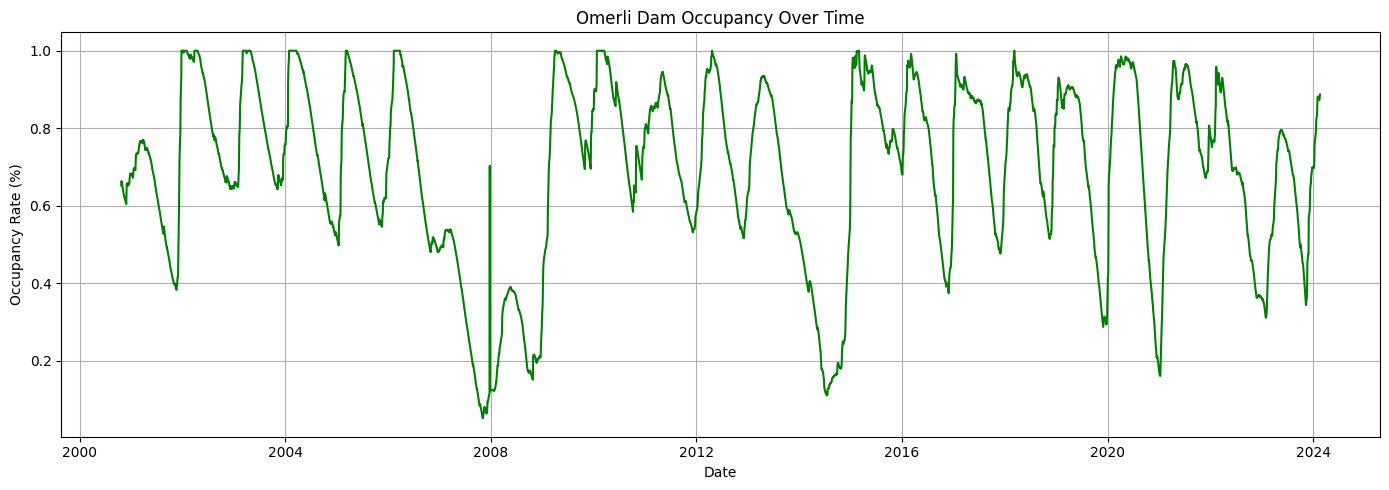

In [56]:
#  Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

# Suppressing warnings for clean output
warnings.filterwarnings('ignore')

# ==============================
# 🔹 GENERAL DATASET CLEANING
# ==============================

df_general = pd.read_csv("../data/raw/dam_occupancy.csv")

# Converting date
df_general['DATE'] = pd.to_datetime(df_general['DATE'], format='%Y-%m-%d')
df_general.sort_values('DATE', inplace=True)
df_general.reset_index(drop=True, inplace=True)

# Checking missing values
print("Missing values in General Dataset:")
print(df_general.isnull().sum())

# Interpolating missing values
df_general['GENERAL_DAM_OCCUPANCY_RATE'] = df_general['GENERAL_DAM_OCCUPANCY_RATE'].interpolate(method='linear')
df_general['GENERAL_DAM_RESERVED_WATER'] = df_general['GENERAL_DAM_RESERVED_WATER'].interpolate(method='linear')

# Duplicate date check and resolve
df_general = df_general.groupby('DATE', as_index=False).mean()

# Create complete date range
full_range = pd.date_range(start=df_general['DATE'].min(), end=df_general['DATE'].max(), freq='D')
df_general = df_general.set_index('DATE').reindex(full_range).rename_axis('DATE').reset_index()

# Interpolating again if needed
df_general['GENERAL_DAM_OCCUPANCY_RATE'] = df_general['GENERAL_DAM_OCCUPANCY_RATE'].interpolate(method='linear')
df_general['GENERAL_DAM_RESERVED_WATER'] = df_general['GENERAL_DAM_RESERVED_WATER'].interpolate(method='linear')

# Outlier detection for occupancy
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='salmon')
plt.title("Outlier Detection - General Dam Occupancy Rate")
plt.tight_layout()
plt.show()

# Time series plot
plt.figure(figsize=(14, 5))
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], label="General Occupancy", color='steelblue')
plt.title("General Dam Occupancy Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalizing the general occupancy and reserved water columns
from sklearn.preprocessing import MinMaxScaler

scaler_general = MinMaxScaler()
df_general[['GENERAL_DAM_OCCUPANCY_RATE', 'GENERAL_DAM_RESERVED_WATER']] = scaler_general.fit_transform(
    df_general[['GENERAL_DAM_OCCUPANCY_RATE', 'GENERAL_DAM_RESERVED_WATER']]
)

# Save cleaned general dataset
df_general.to_csv("../data/processed/dam_occupancy_cleaned.csv", index=False)


# ==============================
# 🔹 DAM-SPECIFIC DATASET CLEANING
# ==============================

df_dams = pd.read_excel("../data/raw/istanbul-dams-daily-occupancy-rates.xlsx")

# Rename columns to fix corrupted characters
correct_columns = ['Tarih', 'Omerli', 'Darlik', 'Elmali', 'Terkos', 'Alibey',
                   'Buyukcekmece', 'Sazlidere', 'Kazandere', 'Pabucdere', 'Istrancalar']
df_dams.columns = correct_columns

# Convert and sort
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'], dayfirst=True)
df_dams.sort_values('Tarih', inplace=True)
df_dams.reset_index(drop=True, inplace=True)

# Checking missing values
print("\nMissing values in Dam-Specific Dataset:")
print(df_dams.isnull().sum())

# Group and reindex to full date range
df_dams = df_dams.groupby('Tarih', as_index=False).mean()
full_range_dams = pd.date_range(start=df_dams['Tarih'].min(), end=df_dams['Tarih'].max(), freq='D')
df_dams = df_dams.set_index('Tarih').reindex(full_range_dams).rename_axis('Tarih').reset_index()

# Forward-fill missing values
df_dams.fillna(method='ffill', inplace=True)

# Outlier detection for one sample dam (e.g., Omerli)
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_dams['Omerli'], color='lightblue')
plt.title("Outlier Detection - Omerli Dam")
plt.tight_layout()
plt.show()

# Plot time series for one dam
plt.figure(figsize=(14, 5))
plt.plot(df_dams['Tarih'], df_dams['Omerli'], label='Omerli Dam', color='green')
plt.title("Omerli Dam Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalizing occupancy values for all individual dams
scaler_dams = MinMaxScaler()
dam_columns = df_dams.columns.difference(['Tarih'])
df_dams[dam_columns] = scaler_dams.fit_transform(df_dams[dam_columns])



# Save cleaned dam-specific dataset
df_dams.to_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv", index=False)

## Correlation Controls

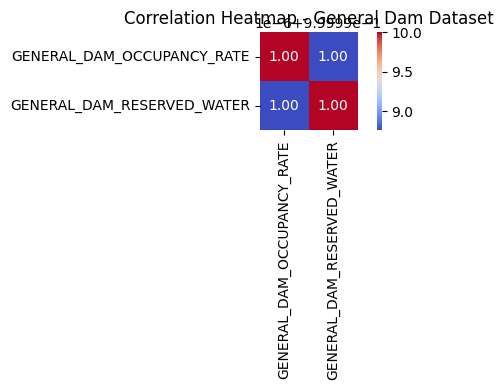

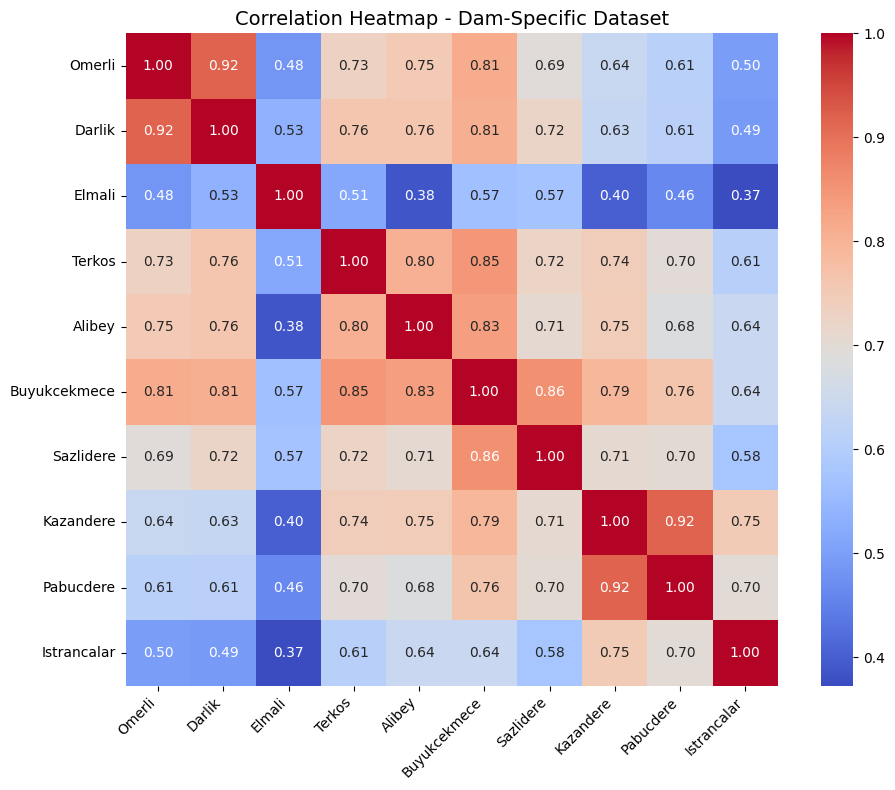

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
#  Correlation for General Dataset
# ==============================

# Loading cleaned general dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Correlation matrix for numerical columns
plt.figure(figsize=(6, 4))
sns.heatmap(df_general.drop(columns='DATE').corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - General Dam Dataset", fontsize=12)
plt.tight_layout()
plt.show()


# ==============================
#  Correlation for Dam-Specific Dataset
# ==============================

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Compute correlation matrix (excluding date)
correlation_matrix = df_dams.drop(columns='Tarih').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - Dam-Specific Dataset", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Merging and Preprocessing

In [66]:
###  Merging and Preprocessing: General Dam Dataset + Rainfall & Consumption

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

# Loading cleaned general dam dataset
df_general = pd.read_csv("../data/processed/dam_occupancy_cleaned.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Loading rainfall and consumption dataset
df_rainfall = pd.read_excel("../data/raw/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri.xlsx")
df_rainfall['Tarih'] = pd.to_datetime(df_rainfall['Tarih'])

# Standardizing column names for merging
df_rainfall.rename(columns={'Tarih': 'DATE'}, inplace=True)

# Merging datasets on DATE
merged_general = pd.merge(df_general, df_rainfall, on='DATE', how='inner')

merged_general = merged_general.loc[:, ~merged_general.columns.str.contains('^Unnamed')]


# Handling outliers using IQR method
Q1 = merged_general.drop(columns='DATE').quantile(0.25)
Q3 = merged_general.drop(columns='DATE').quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

merged_general.update(merged_general.drop(columns='DATE').clip(lower=lower_bound, upper=upper_bound, axis=1))


# Checking for null values
print("\nMissing values in merged general dam dataset:")
print(merged_general.isnull().sum())

# Filling missing values with linear interpolation
merged_general.interpolate(method='linear', inplace=True)

# Sorting and resetting index
merged_general.sort_values('DATE', inplace=True)
merged_general.reset_index(drop=True, inplace=True)

# Normalizing numerical columns in the merged general dam dataset
scaler_merged_general = MinMaxScaler()
numerical_cols_general = merged_general.columns.difference(['DATE'])
merged_general[numerical_cols_general] = scaler_merged_general.fit_transform(merged_general[numerical_cols_general])

# Renaming the water consumption column to English
merged_general.rename(columns={"İstanbul günlük tüketim(m³/gün)": "Istanbul_Daily_Consumption"}, inplace=True)

# Renaming columns to standardized English format
renamed_columns = {}
for col in merged_general.columns:
    if "_x" in col:
        new_name = col.replace("_x", "_Fill")
    elif "_y" in col:
        new_name = col.replace("_y", "_Rainfall")
    else:
        new_name = col
    new_name = (new_name.replace("Ö", "O").replace("ö", "o")
                        .replace("Ü", "U").replace("ü", "u")
                        .replace("Ş", "S").replace("ş", "s")
                        .replace("İ", "I").replace("ı", "i")
                        .replace("Ç", "C").replace("ç", "c")
                        .replace("Ğ", "G").replace("ğ", "g"))
    renamed_columns[col] = new_name

merged_general.rename(columns=renamed_columns, inplace=True)

# Saving the merged dataset
merged_general.to_csv("../data/processed/merged_general_dam.csv", index=False)
print("\nSaved: ../data/processed/merged_general_dam.csv")


###  Merging and Preprocessing: Dam-Specific Dataset + Rainfall & Consumption

# Loading cleaned dam-specific dataset
df_dams = pd.read_csv("../data/processed/istanbul-dams-daily-occupancy-rates-cleaned.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])

# Standardizing for merging
df_rainfall_specific = pd.read_excel("../data/raw/istanbul-barajlarnda-yagis-ve-gunluk-tuketim-verileri.xlsx")
df_rainfall_specific['Tarih'] = pd.to_datetime(df_rainfall_specific['Tarih'])

# Merging on Tarih
merged_dam_specific = pd.merge(df_dams, df_rainfall_specific, on='Tarih', how='inner')

merged_dam_specific = merged_dam_specific.loc[:, ~merged_dam_specific.columns.str.contains('^Unnamed')]
merged_dam_specific.columns.tolist()
    
# Handling outliers using IQR method
Q1_dams = merged_dam_specific.drop(columns='Tarih').quantile(0.25)
Q3_dams = merged_dam_specific.drop(columns='Tarih').quantile(0.75)
IQR_dams = Q3_dams - Q1_dams
lower_bound_dams = Q1_dams - 1.5 * IQR_dams
upper_bound_dams = Q3_dams + 1.5 * IQR_dams

merged_dam_specific.update(
    merged_dam_specific.drop(columns='Tarih').clip(lower=lower_bound_dams, upper=upper_bound_dams, axis=1)
)

    

# Null check
print("\nMissing values in merged dam-specific dataset:")
print(merged_dam_specific.isnull().sum())

# Normalizing numerical columns in the merged dam-specific dataset
scaler_merged_dams = MinMaxScaler()
numerical_cols_dams = merged_dam_specific.columns.difference(['Tarih'])
merged_dam_specific[numerical_cols_dams] = scaler_merged_dams.fit_transform(merged_dam_specific[numerical_cols_dams])

# Interpolation to handle any remaining missing values
merged_dam_specific.interpolate(method='linear', inplace=True)

# Sorting and resetting index
merged_dam_specific.sort_values('Tarih', inplace=True)
merged_dam_specific.reset_index(drop=True, inplace=True)


# Renaming the water consumption column to English
merged_dam_specific.rename(columns={"İstanbul günlük tüketim(m³/gün)": "Istanbul_Daily_Consumption"}, inplace=True)

# Renaming columns to standardized English format
renamed_columns = {}
for col in merged_dam_specific.columns:
    if "_x" in col:
        new_name = col.replace("_x", "_Fill")
    elif "_y" in col:
        new_name = col.replace("_y", "_Rainfall")
    else:
        new_name = col
    new_name = (new_name.replace("Ö", "O").replace("ö", "o")
                        .replace("Ü", "U").replace("ü", "u")
                        .replace("Ş", "S").replace("ş", "s")
                        .replace("İ", "I").replace("ı", "i")
                        .replace("Ç", "C").replace("ç", "c")
                        .replace("Ğ", "G").replace("ğ", "g"))
    renamed_columns[col] = new_name

merged_dam_specific.rename(columns=renamed_columns, inplace=True)

# Saving the final merged dataset
merged_dam_specific.to_csv("../data/processed/merged_dam_specific.csv", index=False)
print("\nSaved: ../data/processed/merged_dam_specific.csv")
print(merged_dam_specific.head())


Missing values in merged general dam dataset:
DATE                               0
GENERAL_DAM_OCCUPANCY_RATE         0
GENERAL_DAM_RESERVED_WATER         0
Ömerli                             0
Darlik                             0
Elmali                             0
Terkos                             0
B.çekmece                          0
Sazlidere                          0
Alibey                             0
Kazandere                          0
Pabuçdere                          0
ıstırancalar                       0
İstanbul günlük tüketim(m³/gün)    0
dtype: int64

Saved: ../data/processed/merged_general_dam.csv

Missing values in merged dam-specific dataset:
Tarih                              0
Omerli                             0
Darlik_x                           0
Elmali_x                           0
Terkos_x                           0
Alibey_x                           0
Buyukcekmece                       0
Sazlidere_x                        0
Kazandere_x                  

## EDA and Outlier Analysis for Merged General Dam Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750 entries, 0 to 3749
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   DATE                             3750 non-null   datetime64[ns]
 1   GENERAL_DAM_OCCUPANCY_RATE       3750 non-null   float64       
 2   GENERAL_DAM_RESERVED_WATER       3750 non-null   float64       
 3   Ömerli                           3750 non-null   float64       
 4   Darlik                           3750 non-null   float64       
 5   Elmali                           3750 non-null   float64       
 6   Terkos                           3750 non-null   float64       
 7   B.çekmece                        3750 non-null   float64       
 8   Sazlidere                        3750 non-null   float64       
 9   Alibey                           3750 non-null   float64       
 10  Kazandere                        3750 non-null   float64    

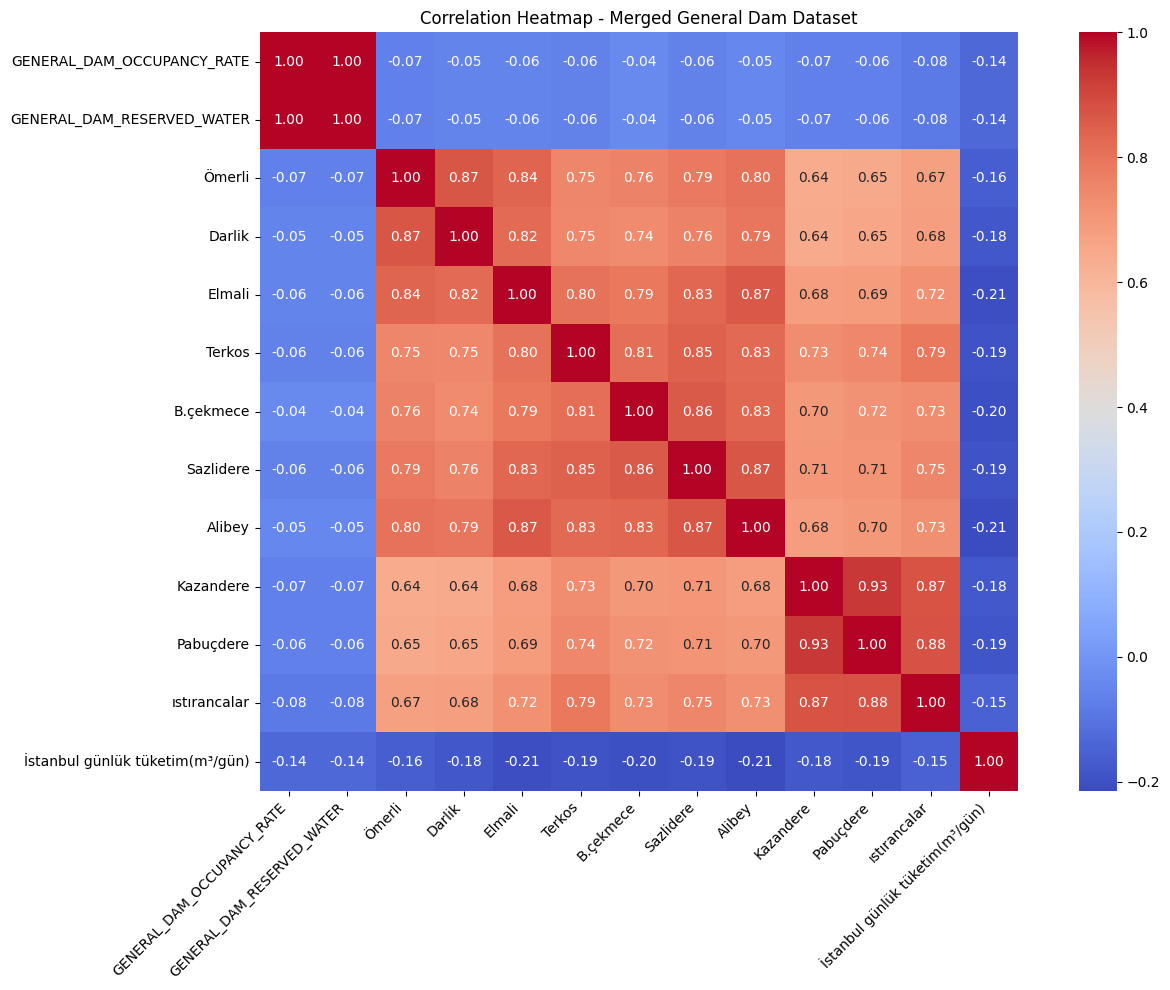

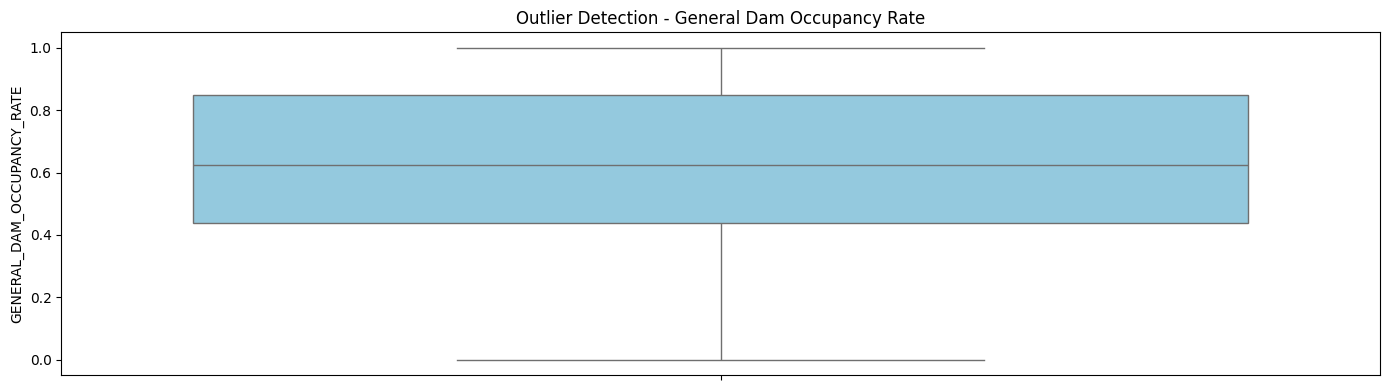

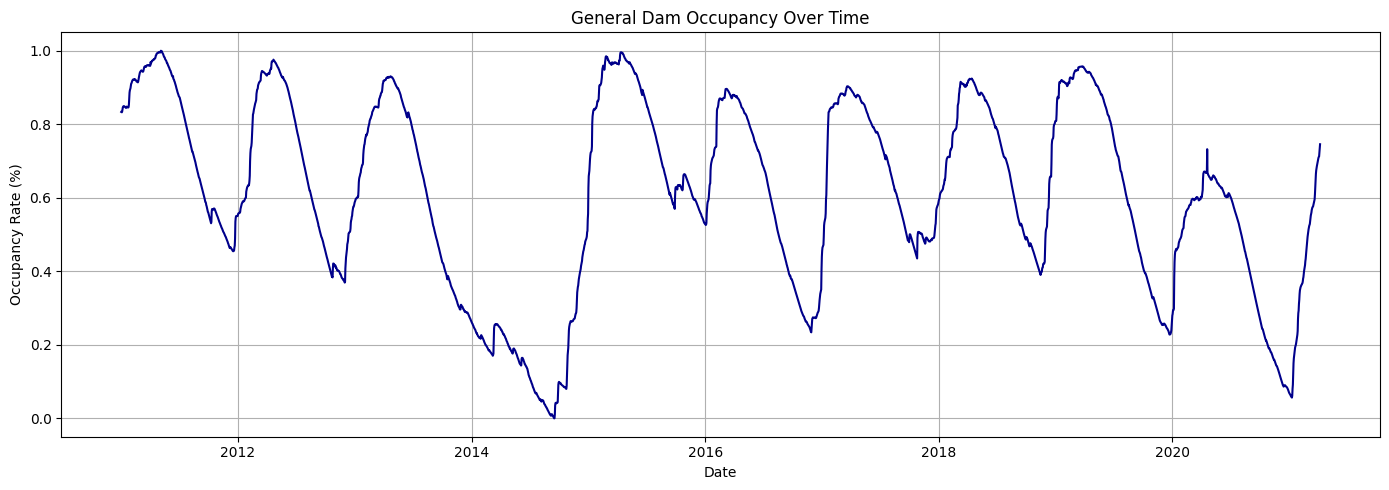

In [59]:
# Loading merged general dam dataset
df_general = pd.read_csv("../data/processed/merged_general_dam.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])

# Displaying general structure
print(df_general.info())
print(df_general.describe())

# Checking missing values
missing_values = df_general.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(df_general.drop(columns=["DATE"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - Merged General Dam Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Outlier detection via boxplots
plt.figure(figsize=(14, 4))
sns.boxplot(data=df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='skyblue')
plt.title("Outlier Detection - General Dam Occupancy Rate")
plt.tight_layout()
plt.show()

# Trend line for general dam occupancy
plt.figure(figsize=(14, 5))
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], label='Occupancy Rate', color='darkblue')
plt.title("General Dam Occupancy Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


## EDA and Outlier Analysis for Merged Dam-Specific Dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4797 entries, 0 to 4796
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Tarih                            4797 non-null   datetime64[ns]
 1   Omerli                           4797 non-null   float64       
 2   Darlik_x                         4797 non-null   float64       
 3   Elmali_x                         4797 non-null   float64       
 4   Terkos_x                         4797 non-null   float64       
 5   Alibey_x                         4797 non-null   float64       
 6   Buyukcekmece                     4797 non-null   float64       
 7   Sazlidere_x                      4797 non-null   float64       
 8   Kazandere_x                      4797 non-null   float64       
 9   Pabucdere                        4797 non-null   float64       
 10  Istrancalar                      4797 non-null   float64    

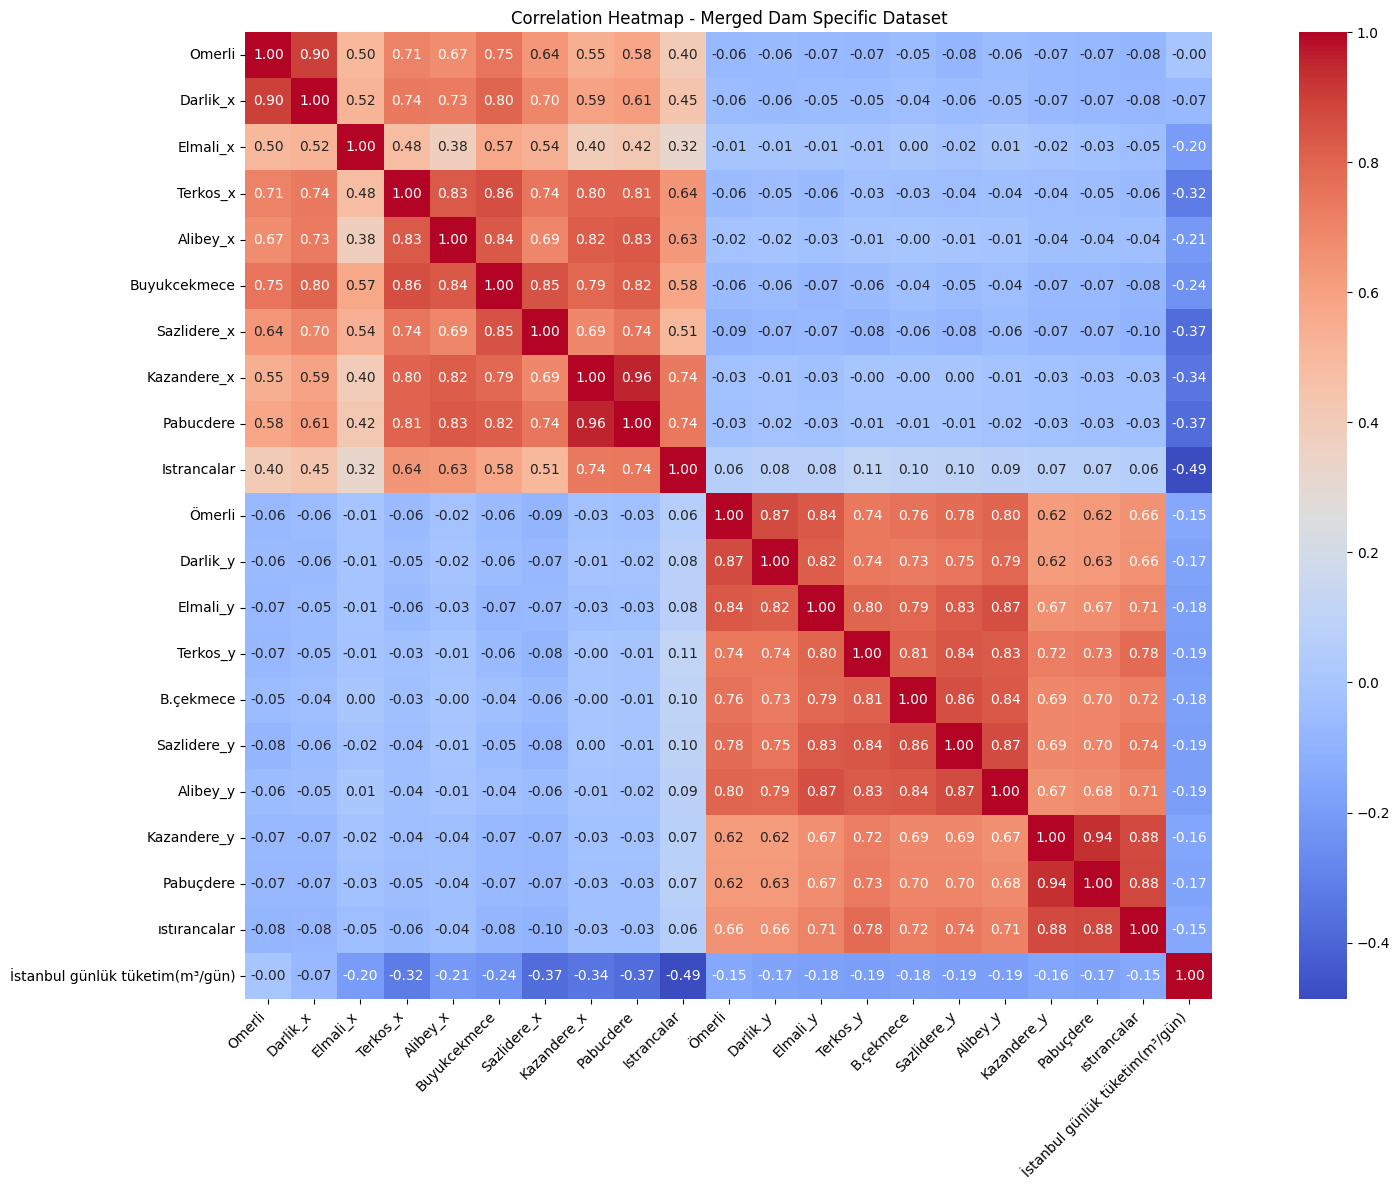

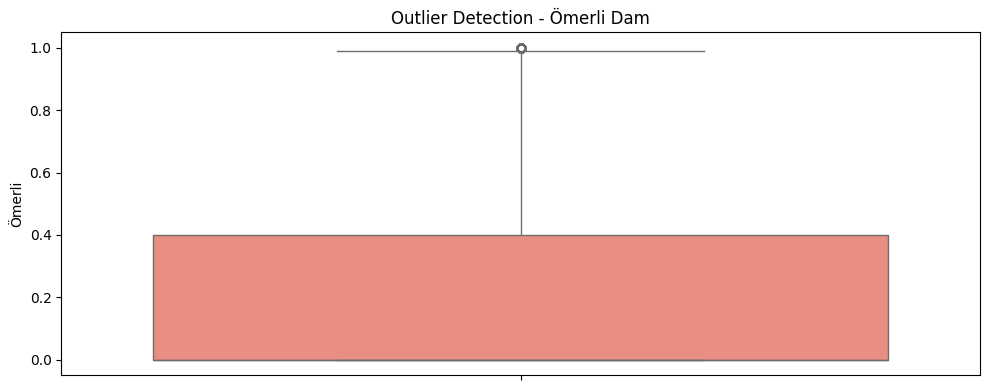

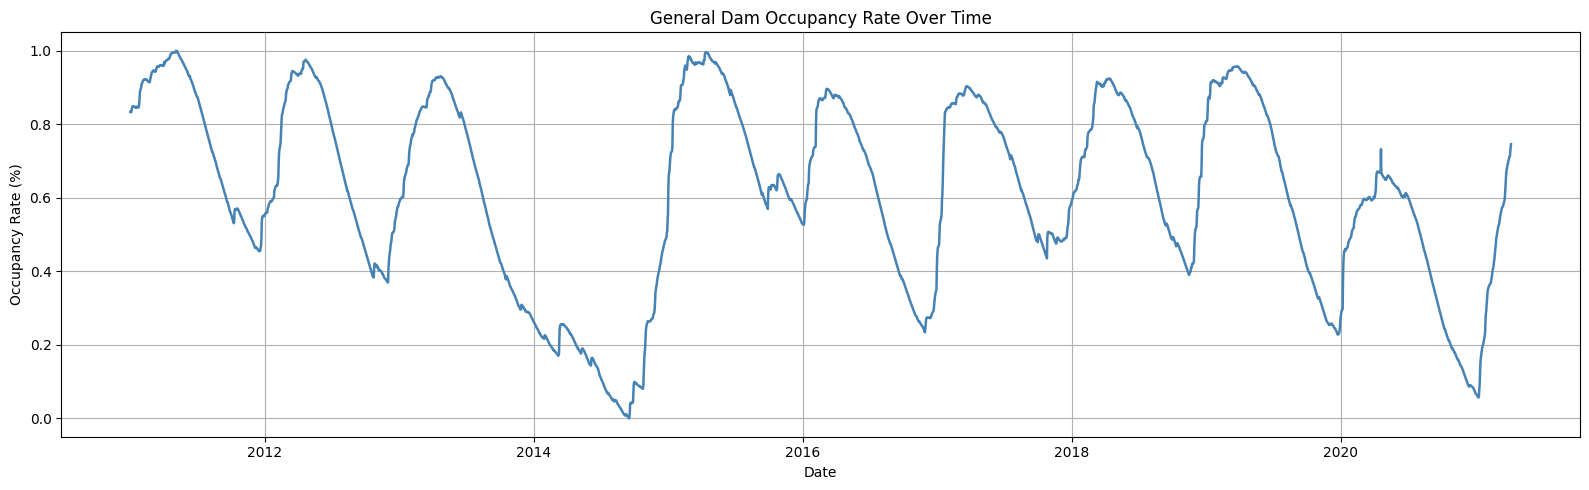

In [60]:
# Loading merged dam-specific dataset
df_specific = pd.read_csv("../data/processed/merged_dam_specific.csv")
df_specific['Tarih'] = pd.to_datetime(df_specific['Tarih'])

# Displaying general structure
print(df_specific.info())
print(df_specific.describe())

# Checking missing values
missing_values = df_specific.isnull().sum()
print("Missing values:\n", missing_values[missing_values > 0])

# Correlation heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(df_specific.drop(columns=["Tarih"]).corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap - Merged Dam Specific Dataset")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Outlier detection - Ömerli as example
plt.figure(figsize=(10, 4))
sns.boxplot(data=df_specific['Ömerli'], color='salmon')
plt.title("Outlier Detection - Ömerli Dam")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='steelblue', linewidth=1.8)
plt.title("General Dam Occupancy Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()








## General Dam Occupancy + Water Consumption Plot

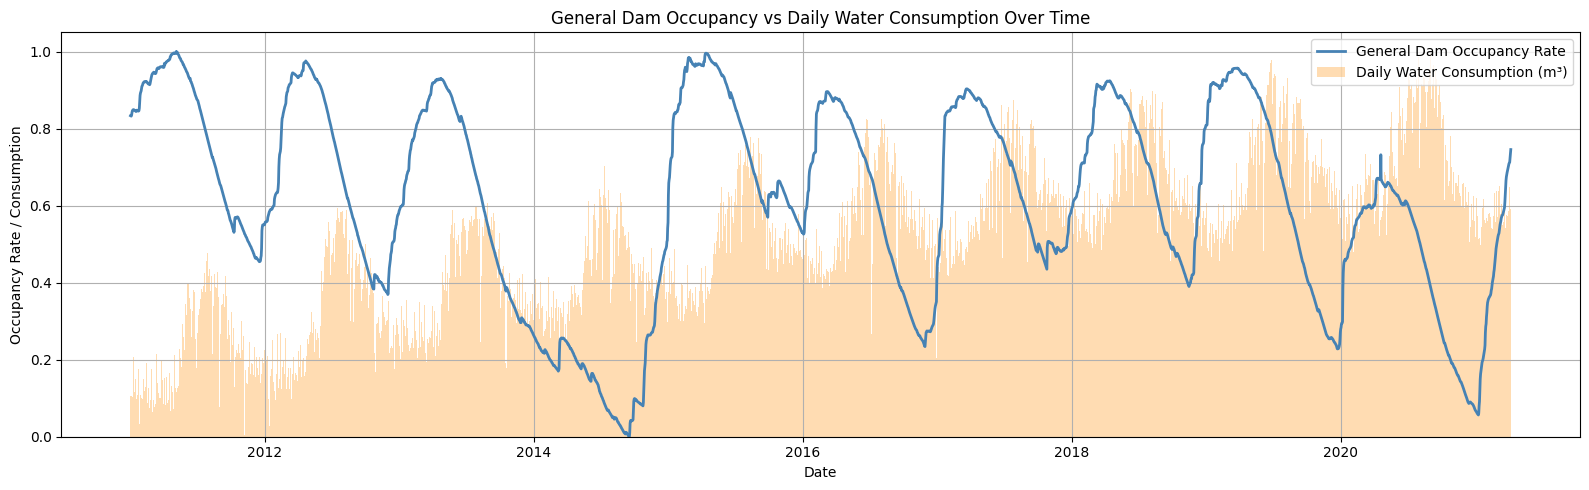

In [68]:
# Loading merged general dam dataset
df_general = pd.read_csv("../data/processed/merged_general_dam.csv")
df_general['DATE'] = pd.to_datetime(df_general['DATE'])
df_general.sort_values('DATE', inplace=True)

plt.figure(figsize=(16, 5))

# Plotting dam occupancy rate
plt.plot(df_general['DATE'], df_general['GENERAL_DAM_OCCUPANCY_RATE'], color='steelblue',
         linewidth=2, label='General Dam Occupancy Rate')

# Plotting daily water consumption as vertical bars
plt.bar(df_general['DATE'], df_general['Istanbul_Daily_Consumption'], width=1.0, alpha=0.3,
        color='darkorange', label='Daily Water Consumption (m³)')

plt.title("General Dam Occupancy vs Daily Water Consumption Over Time")
plt.xlabel("Date")
plt.ylabel("Occupancy Rate / Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Dam-Specific Occupancy + Water Consumption

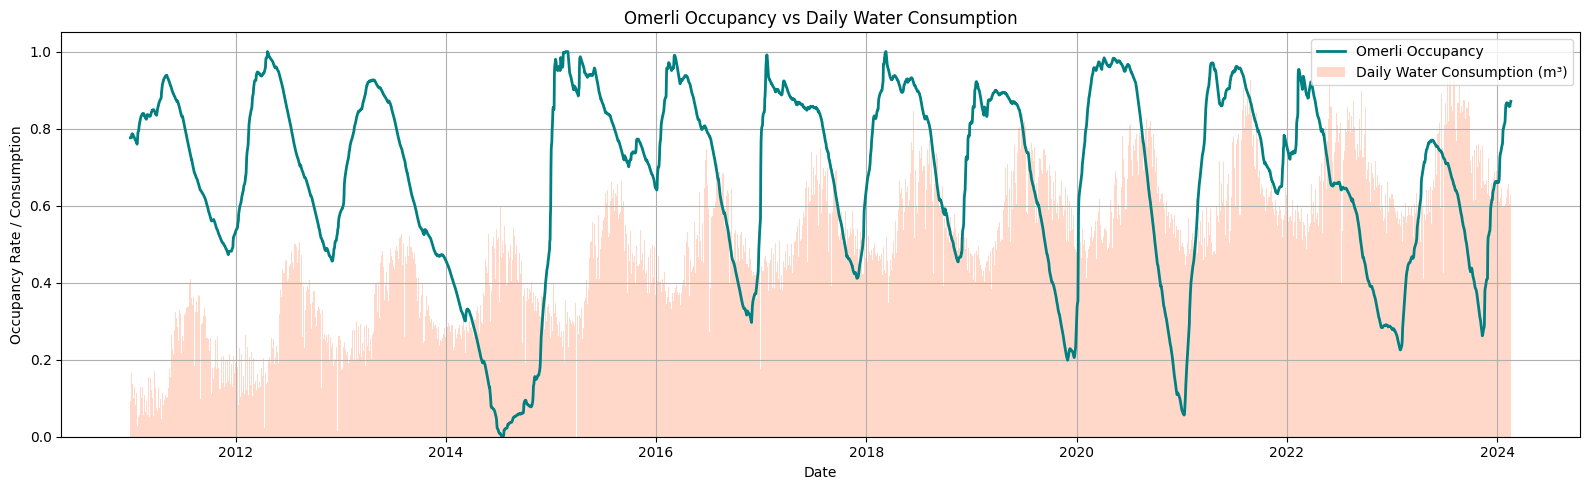

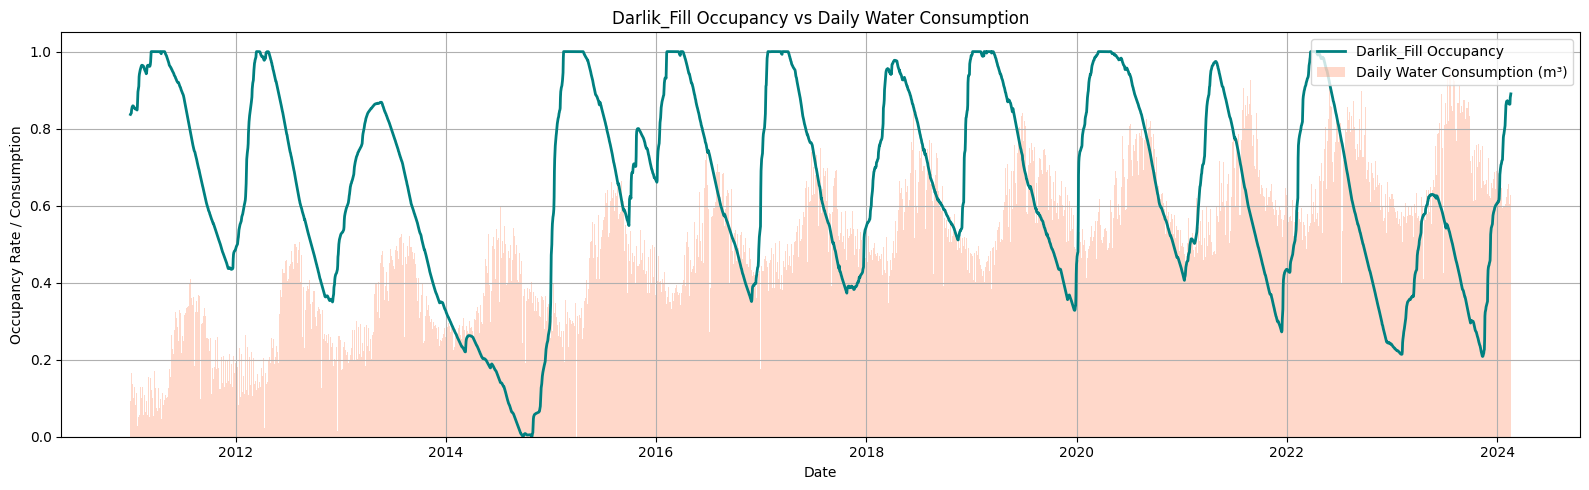

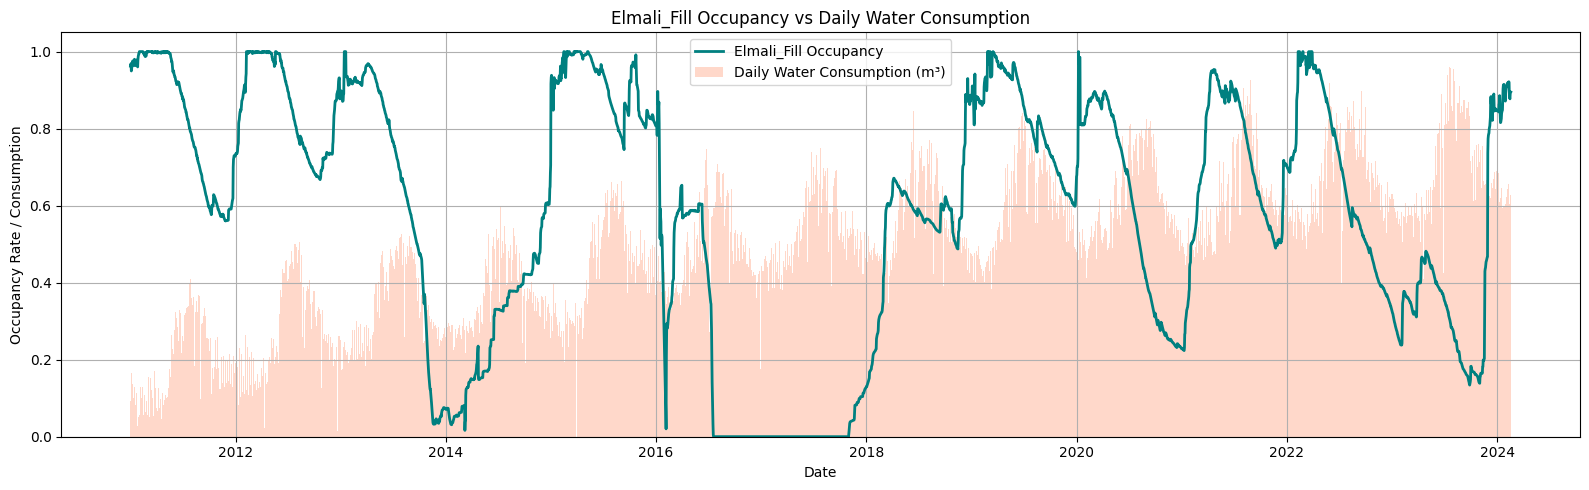

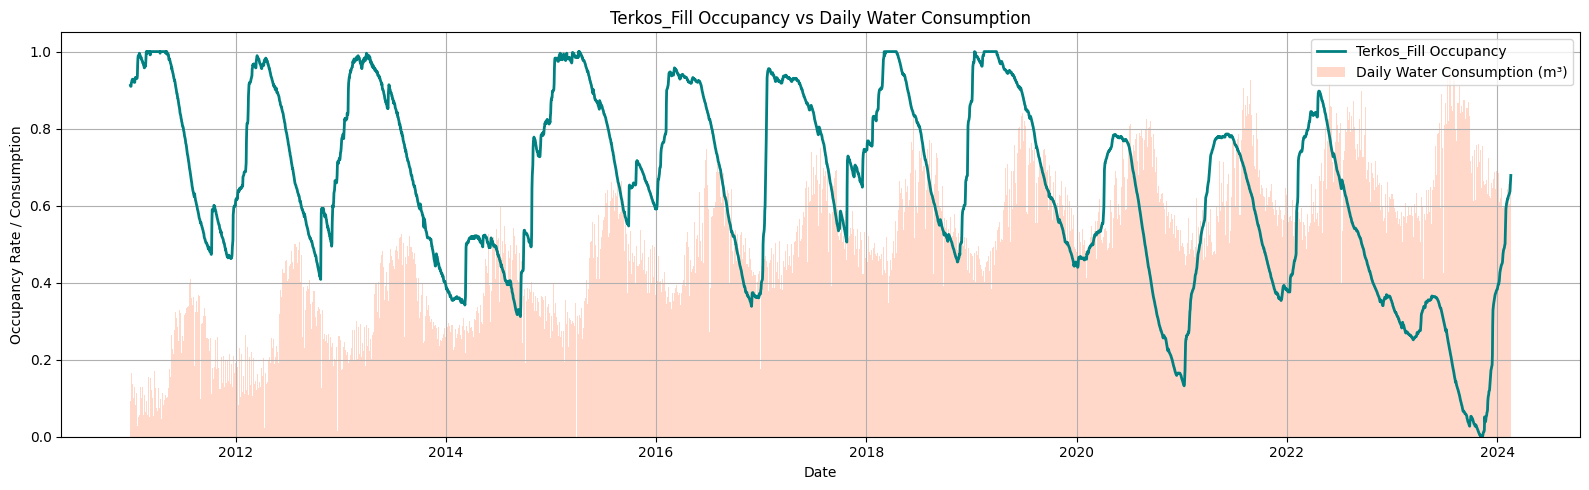

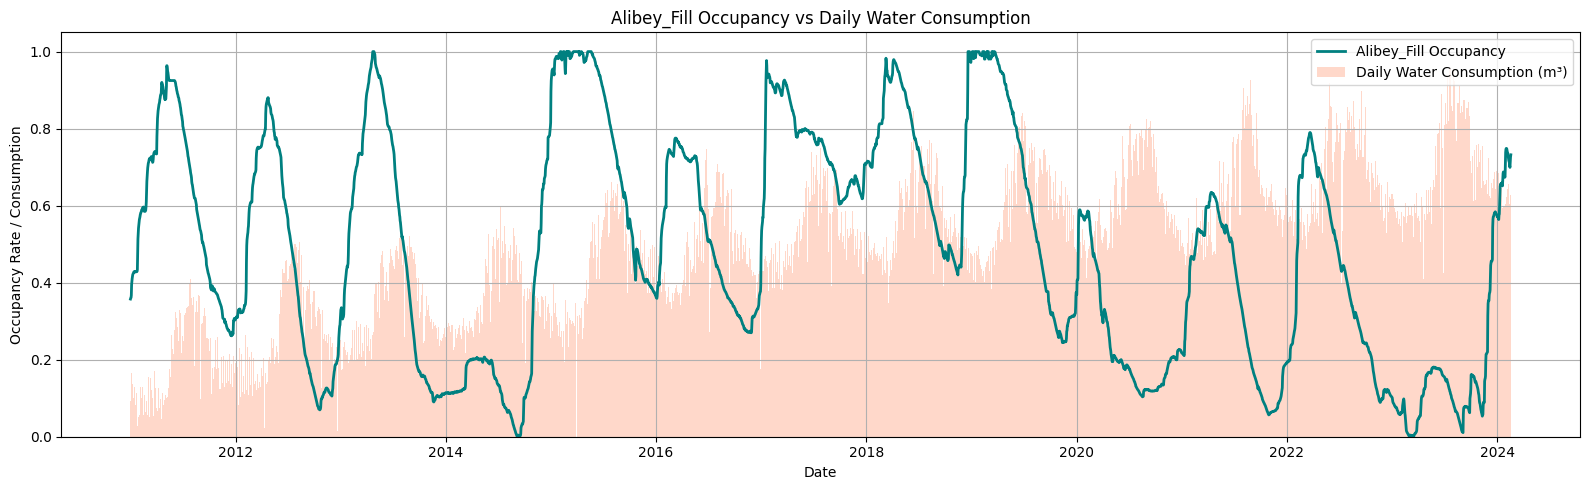

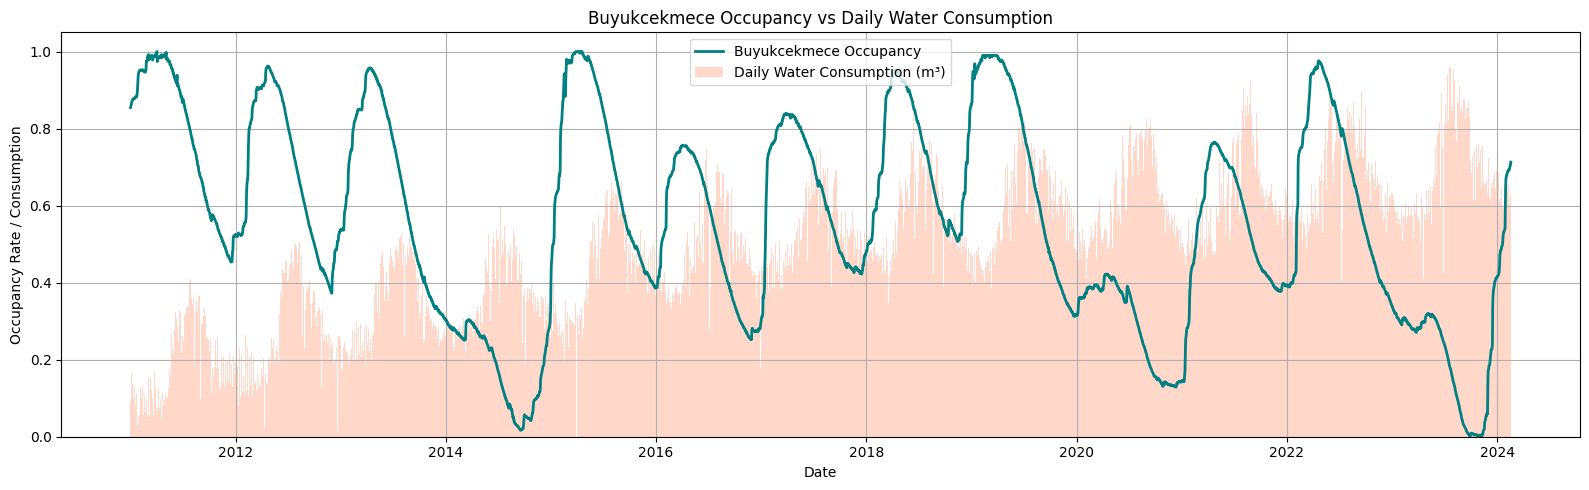

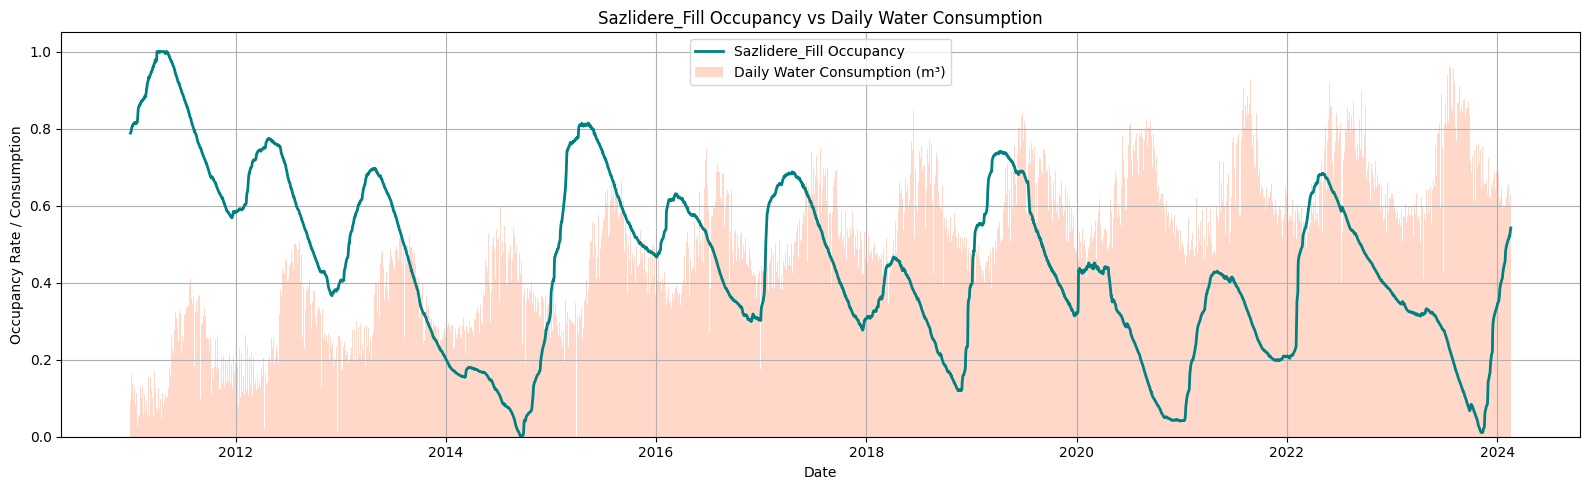

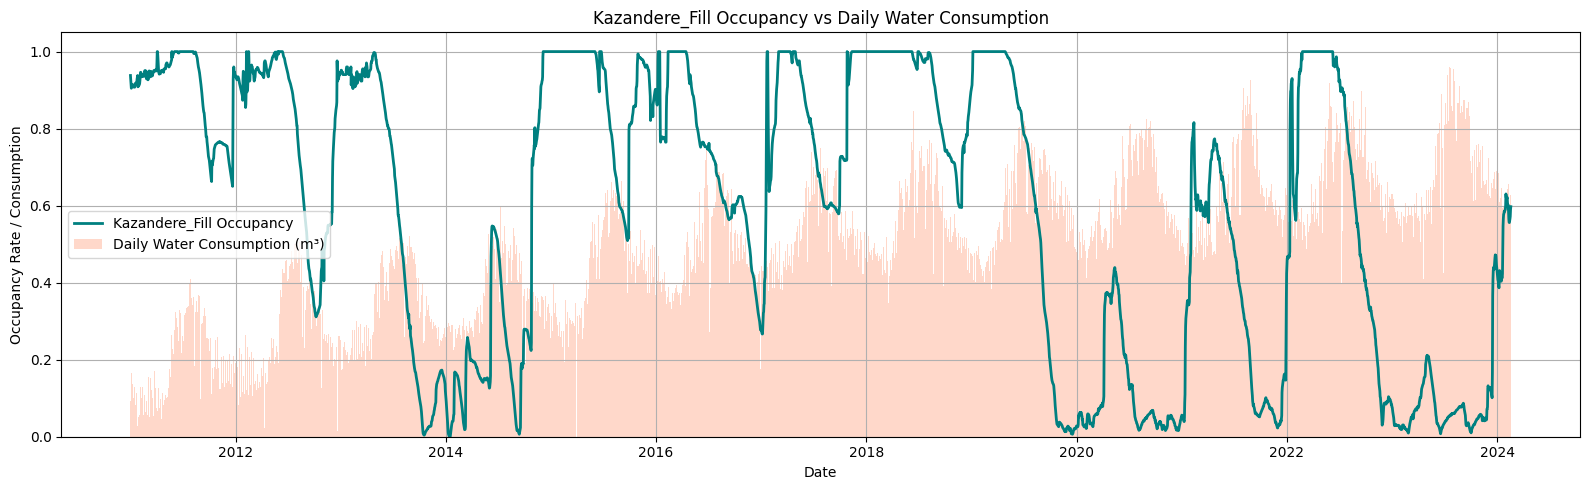

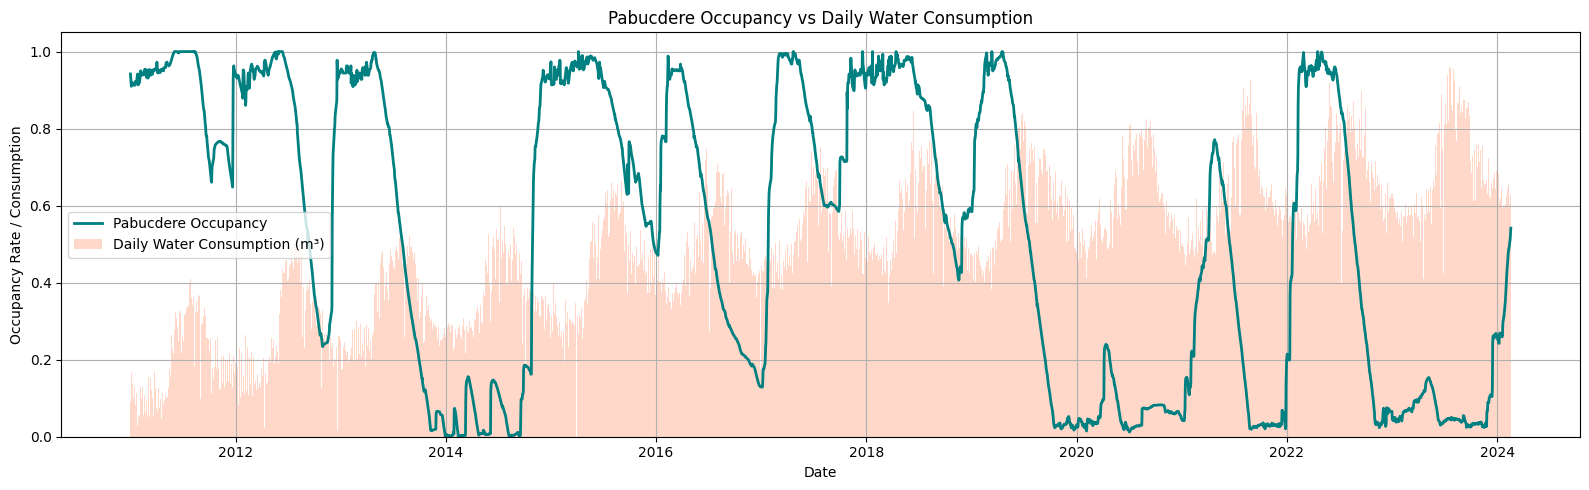

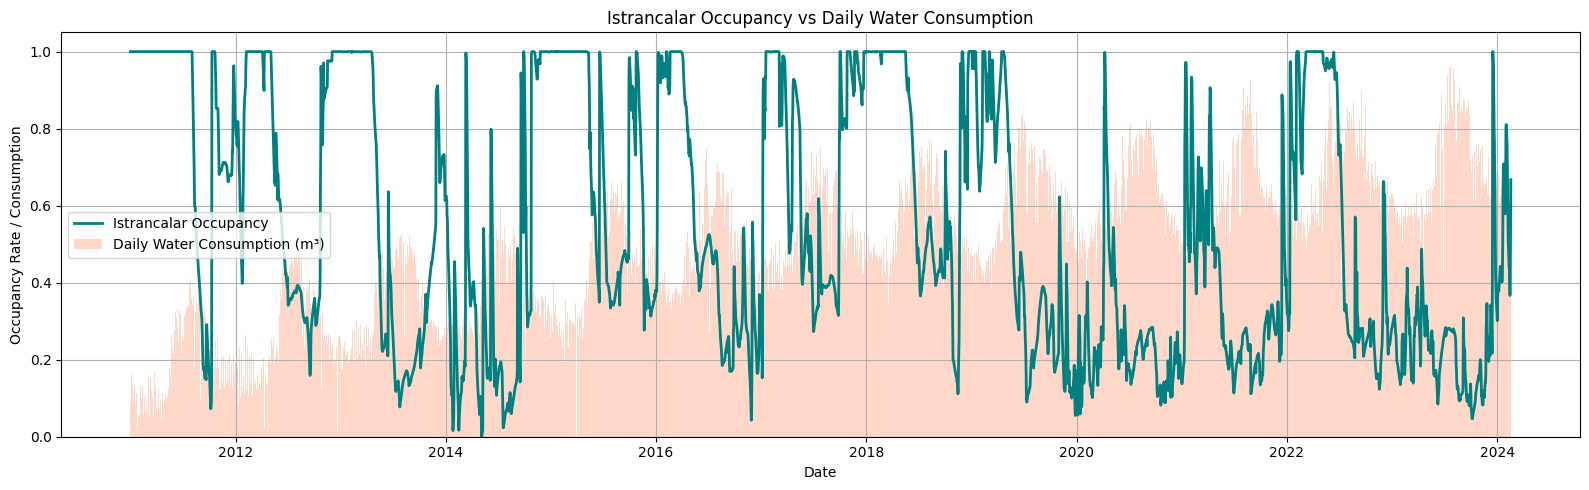

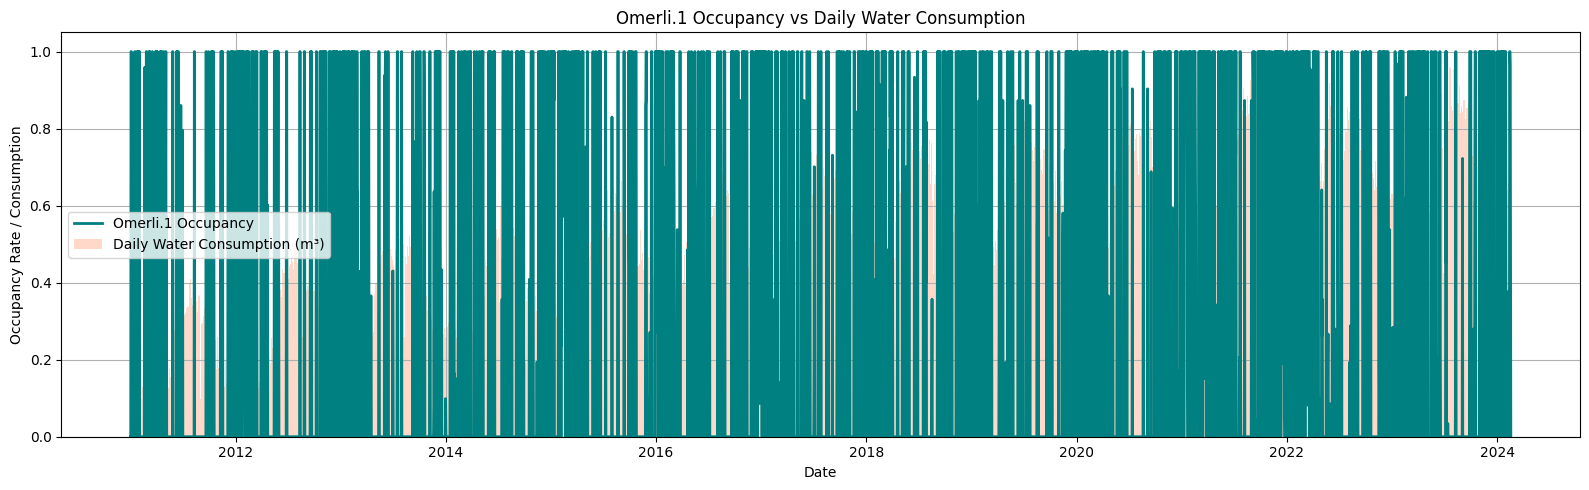

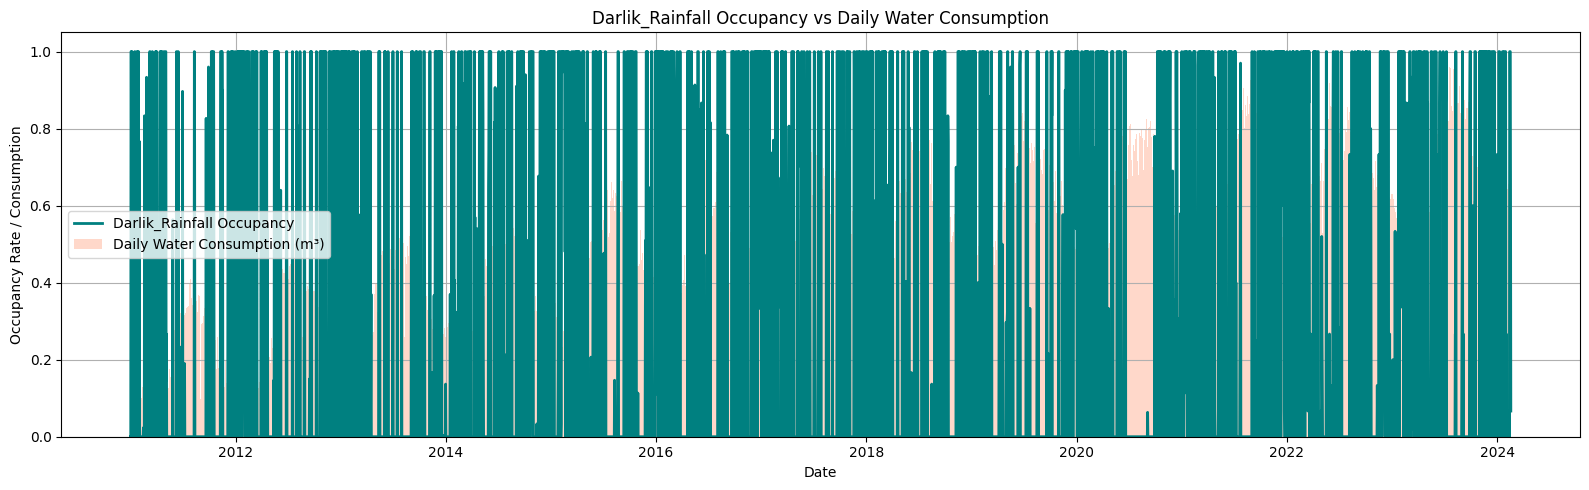

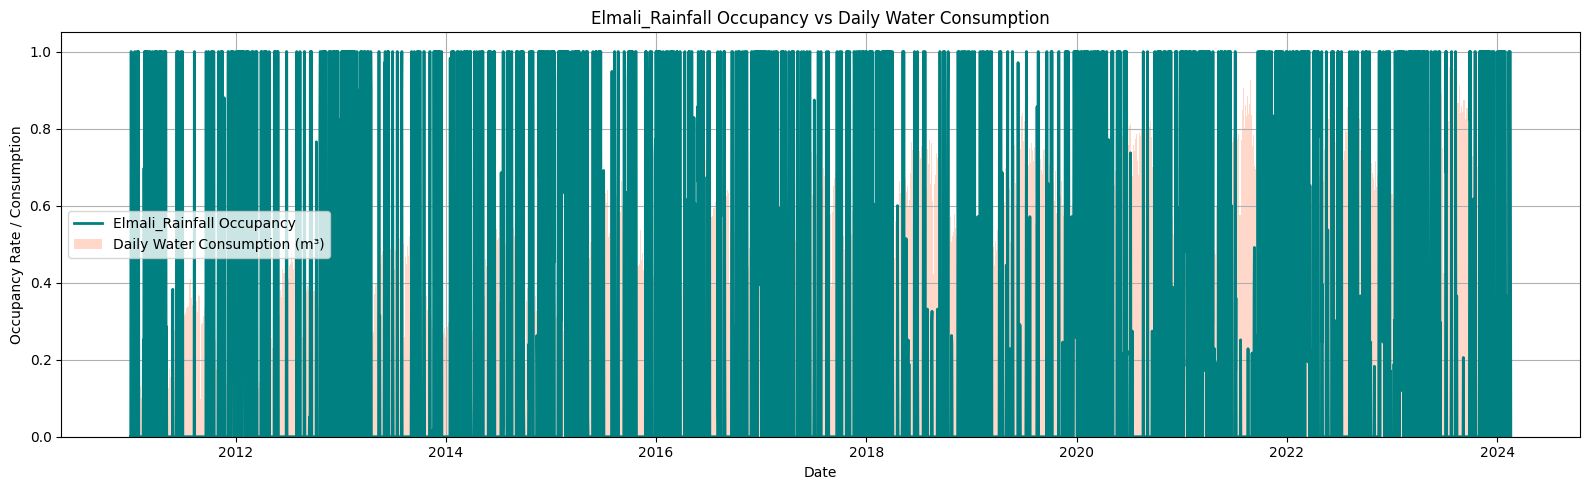

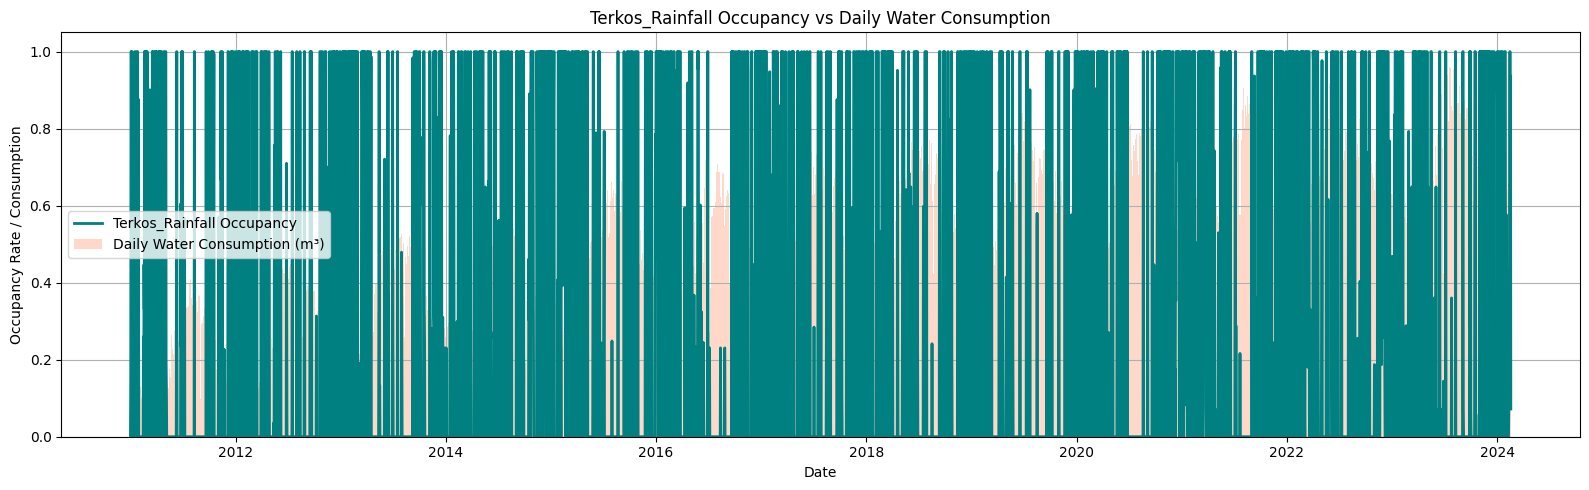

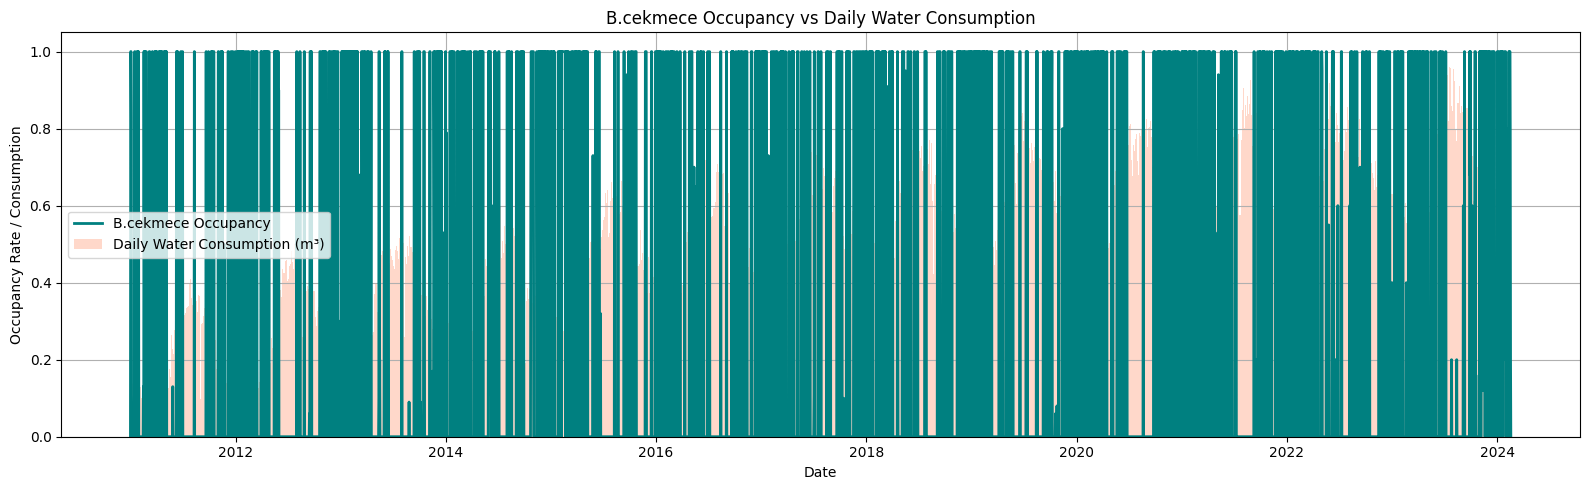

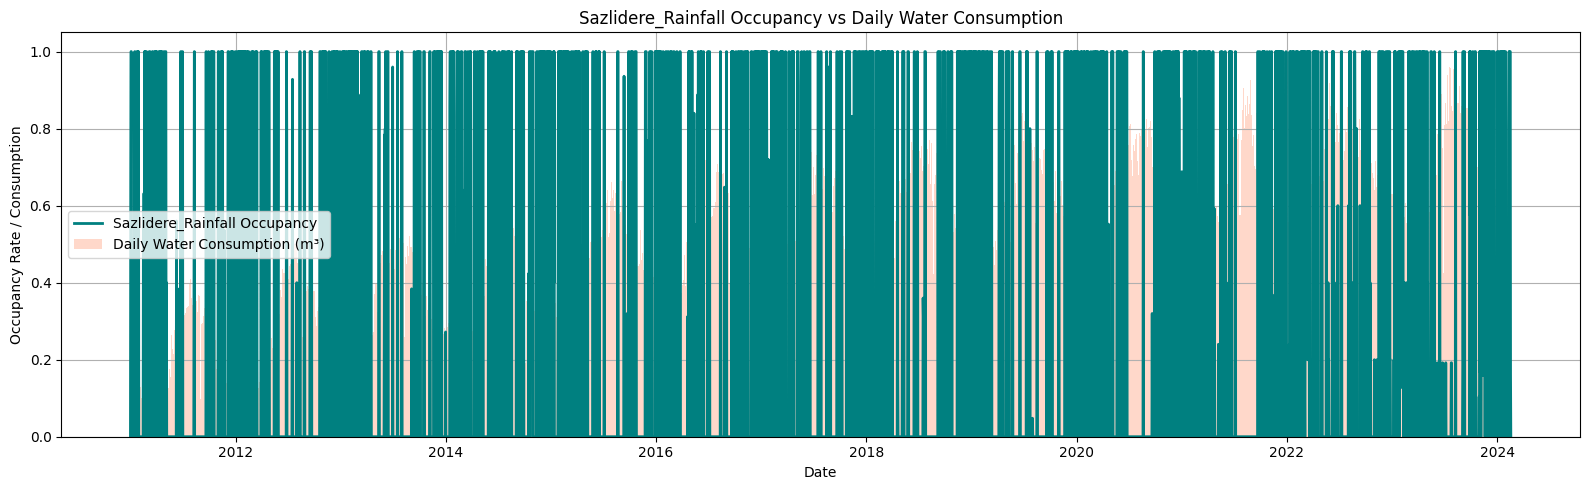

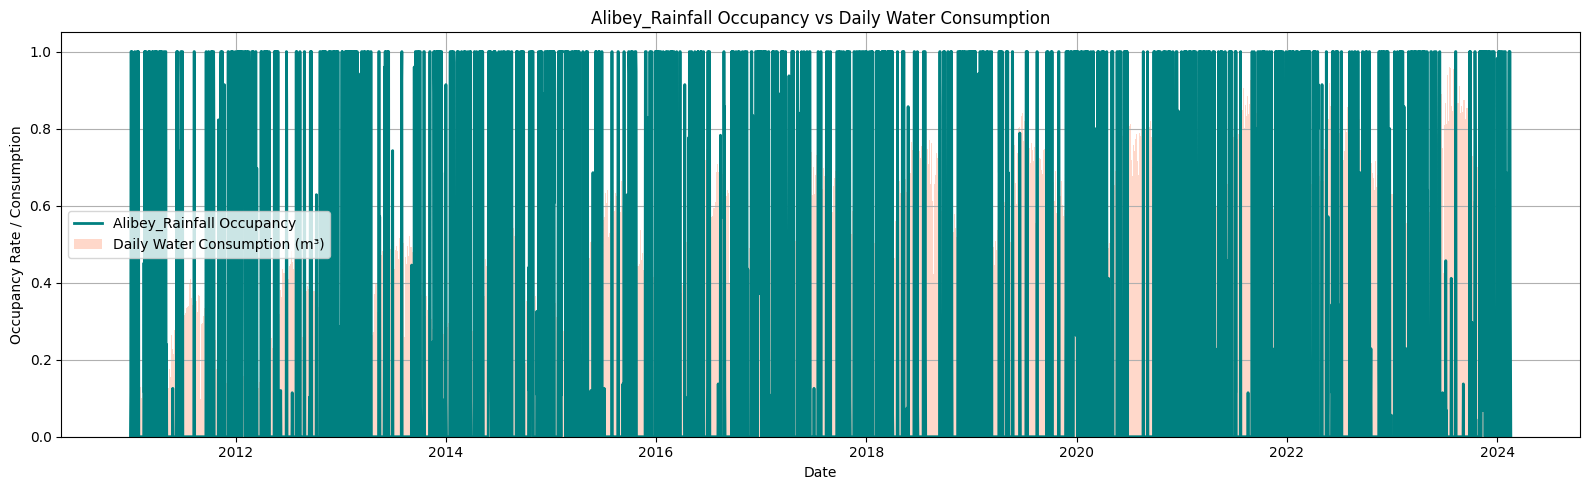

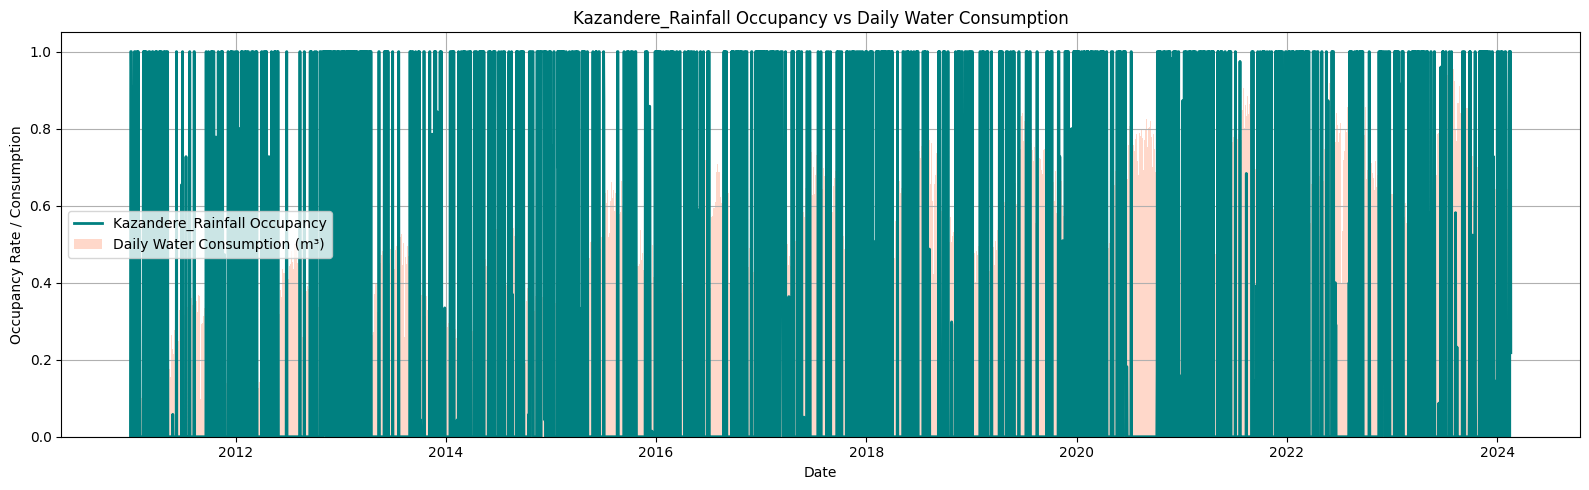

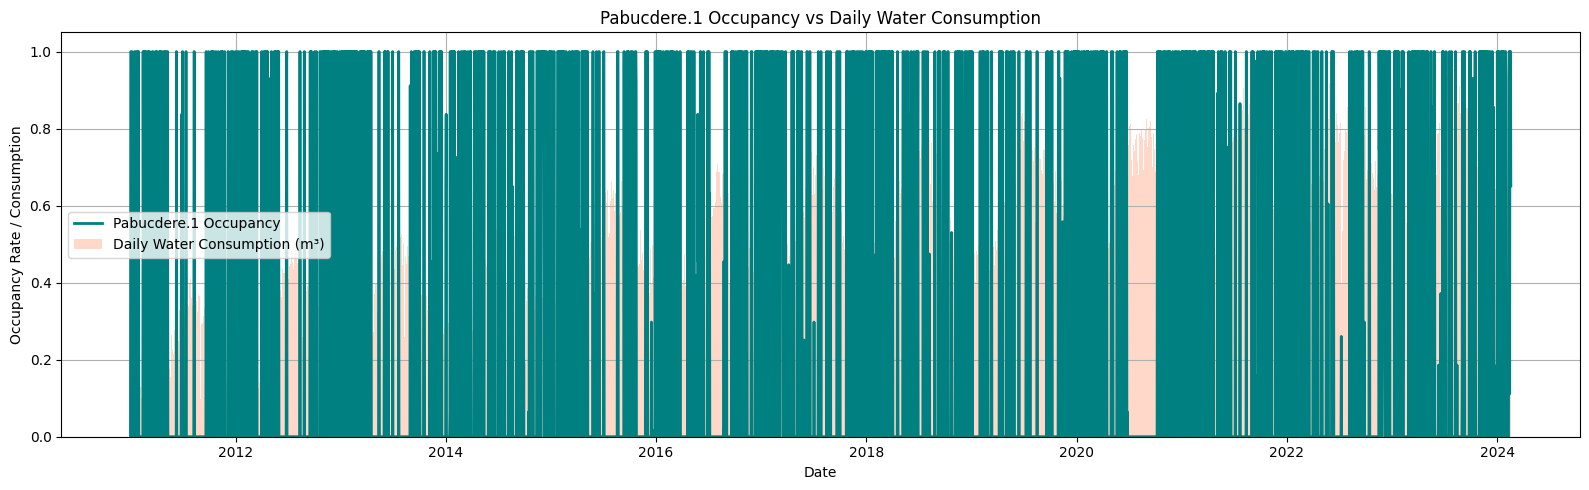

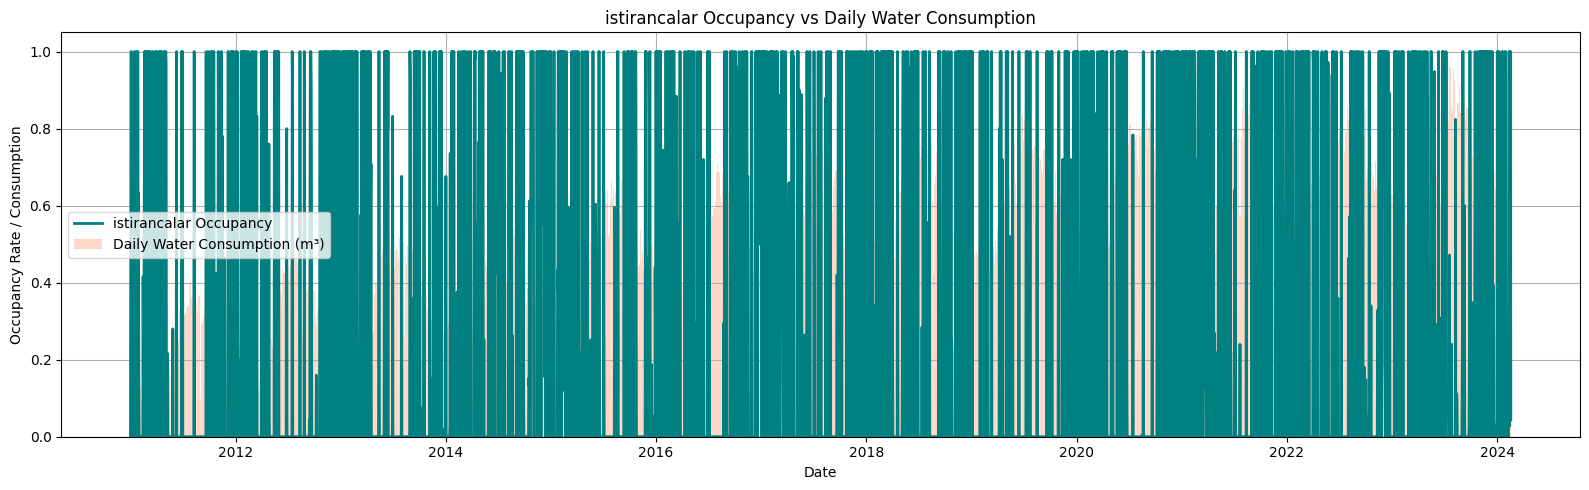

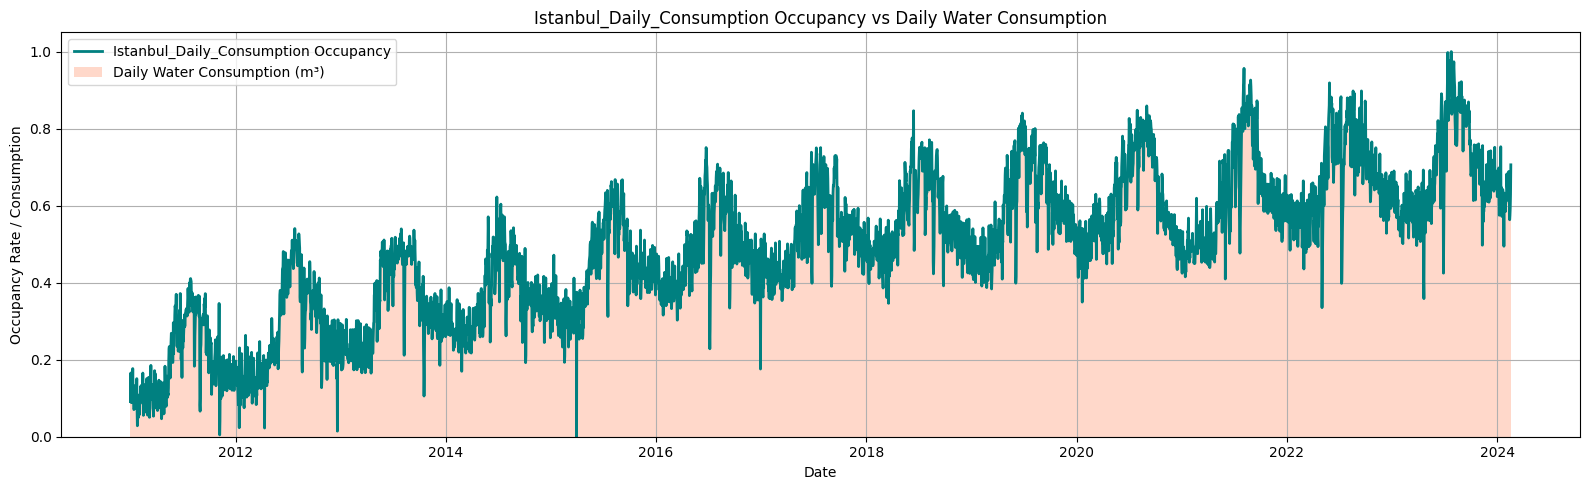

In [70]:
# Loading merged dam-specific dataset
df_dams = pd.read_csv("../data/processed/merged_dam_specific.csv")
df_dams['Tarih'] = pd.to_datetime(df_dams['Tarih'])
df_dams.sort_values('Tarih', inplace=True)

# Getting dam names (excluding Tarih and consumption columns)
dam_columns = [col for col in df_dams.columns if col not in ['Tarih', 'GÜNLÜK SU TÜKETİMİ (m³)', 'TOPLAM YAĞIŞ (mm)']]

for dam in dam_columns:
    plt.figure(figsize=(16, 5))
    
    # Plotting dam occupancy
    plt.plot(df_dams['Tarih'], df_dams[dam], label=f'{dam} Occupancy', color='teal', linewidth=2)

    # Plotting water consumption
    plt.bar(df_dams['Tarih'], df_dams['Istanbul_Daily_Consumption'], width=1.0, alpha=0.3,
            color='coral', label='Daily Water Consumption (m³)')

    plt.title(f"{dam} Occupancy vs Daily Water Consumption")
    plt.xlabel("Date")
    plt.ylabel("Occupancy Rate / Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
